In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Create the inpector previous to send queries in order to know the structure of the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# get the columns names and types of both tables
columns1=inspector.get_columns('measurement')
columns2=inspector.get_columns('station')
print("Columns measurement table\n------------------------")
for c in columns1:
    print(c['name'], c["type"])
print("Columns station table\n------------------------")
for c in columns2:
    print(c['name'], c["type"])

Columns measurement table
------------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
Columns station table
------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

Last Date:  2017-08-23
Query Date:  2016-08-23


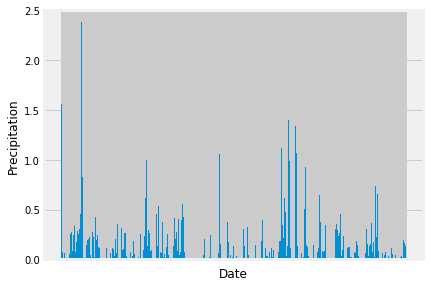

In [14]:
## import required libraries to manages date-time data
import datetime as dt
import pandas as pd
import numpy as np

# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastDate=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastDate=list(np.ravel(lastDate))
lastDate=dt.datetime.strptime(lastDate[0], '%Y-%m-%d').date()
# Calculate the date 1 year ago from the last data point in the database
query_date=lastDate-dt.timedelta(days=365)
print("Last Date: ", lastDate)
print("Query Date: ", query_date)
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
       func.avg(Measurement.prcp)]
Precipitation=session.query(*sel).\
    filter(Measurement.date > query_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(Precipitation, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
# Sort the dataframe by date
df=df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure()
plt.bar(df.index, df.prcp)
plt.tight_layout()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Precipitation', fontsize=12)
plt.xticks(df.index, "")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pd.DataFrame(df.prcp.describe())

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [16]:
# Design a query to show how many stations are available in this dataset?
sel = [func.count(Station.station)]
nStations=np.ravel(session.query(*sel).all())
print(nStations)

[9]


In [17]:
session.query(Station).count()

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.id)]
activityStations=session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activityStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station, 
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]
MostActive=session.query(*sel).\
    filter(Measurement.station==activityStations[0][0]).\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
MostActive

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
sel = [Measurement.station,
       Measurement.date, 
       Measurement.tobs]
Temperature=session.query(*sel).\
    filter(Measurement.date > query_date).\
    filter(Measurement.station == activityStations[0][0]).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
Temperature

[('USC00519281', '2016-08-24', 77.0),
 ('USC00519281', '2016-08-25', 80.0),
 ('USC00519281', '2016-08-26', 80.0),
 ('USC00519281', '2016-08-27', 75.0),
 ('USC00519281', '2016-08-28', 73.0),
 ('USC00519281', '2016-08-29', 78.0),
 ('USC00519281', '2016-08-30', 77.0),
 ('USC00519281', '2016-08-31', 78.0),
 ('USC00519281', '2016-09-01', 80.0),
 ('USC00519281', '2016-09-02', 80.0),
 ('USC00519281', '2016-09-03', 78.0),
 ('USC00519281', '2016-09-04', 78.0),
 ('USC00519281', '2016-09-05', 78.0),
 ('USC00519281', '2016-09-06', 73.0),
 ('USC00519281', '2016-09-07', 74.0),
 ('USC00519281', '2016-09-08', 80.0),
 ('USC00519281', '2016-09-09', 79.0),
 ('USC00519281', '2016-09-10', 77.0),
 ('USC00519281', '2016-09-11', 80.0),
 ('USC00519281', '2016-09-12', 76.0),
 ('USC00519281', '2016-09-13', 79.0),
 ('USC00519281', '2016-09-14', 75.0),
 ('USC00519281', '2016-09-15', 79.0),
 ('USC00519281', '2016-09-16', 78.0),
 ('USC00519281', '2016-09-17', 79.0),
 ('USC00519281', '2016-09-18', 78.0),
 ('USC005192

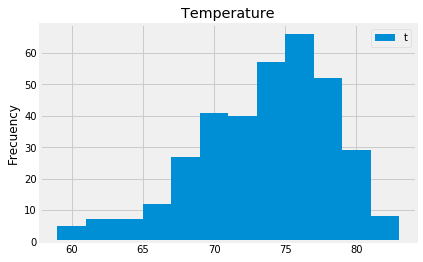

In [21]:
# And plot the results as a histogram
df_tm = pd.DataFrame(Temperature, columns=['station','date','tobs'])
df_tm.tobs.hist(bins=12)
plt.title("Temperature")
plt.ylabel("Frecuency")
plt.legend("tobs")
plt.show()

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
dt=calc_temps('2016-12-15', '2016-12-31')
dt=list(np.ravel(dt))
dt

[60.0, 71.46788990825688, 78.0]

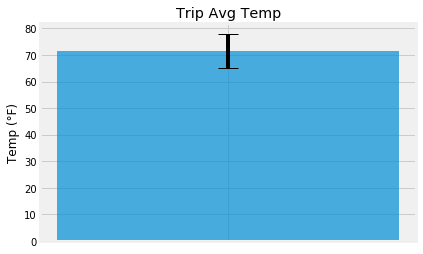

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
ax.bar("",dt[1],
       yerr=dt[2]-dt[1],
       width=0.1,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Temp (°F)')
ax.set_xticks("")
ax.set_title('Trip Avg Temp')
plt.rcParams["figure.figsize"] = (5,10)
ax.yaxis.grid(True)

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]
Rainfall=session.query(*sel).\
    filter(Measurement.date >= '2016-12-15').\
    filter(Measurement.date <= '2016-12-31').\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
pd.DataFrame(Rainfall, columns=["station_id", "Station Name", "latitude", "longitude", "elevation", "Rainfall"])

,station_id,Station Name,latitude,longitude,elevation,Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,10.32
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.28
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.52
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.65
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.98
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.39
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.06


In [ ]:
######## Climate App

In [ ]:
from flask import Flask, jsonify
app = Flask(__name__)

sel = [Measurement.station,
       Measurement.date, 
       Measurement.tobs]
sel2 = [func.avg(Measurement.tobs),
       func.max(Measurement.tobs),
       func.min(Measurement.tobs)]

qTemperature=session.query(*sel).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.station, Measurement.date).all()
session.close()
df_temperature=pd.DataFrame(qTemperature, columns=["Station_id", "date", "tobs"])

@app.route("/")
def welcome():
    """All available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end><br/>"
    )

@app.route("/api/v1.0/precipitation")
def precipitation():
    """Return precipitation data as json"""
    return jsonify(df.to_dict('dict'))
@app.route("/api/v1.0/stations")
def stations():
    """Return stations data as json"""
    dt_stations=pd.DataFrame(engine.execute('SELECT station, name, latitude, longitude, elevation FROM station').fetchall(), columns=["Station_id", "Station_Name", "latitude", "longitude", "elevation"])
    return jsonify(dt_stations.to_dict('dict'))
@app.route("/api/v1.0/tobs")
def tobs():
    """Return temperature data as json"""
    return jsonify(df_temperature.to_dict('dict'))

@app.route("/api/v1.0/<start>")
def query_by_start_date(start):
    """Return temperature data as of start date"""
    qTem_start=session.query(*sel2).\
        filter(Measurement.date > start).all()
    session.close()
    df_tem_start=pd.DataFrame(qTem_start, columns=["TAVG", "TMAX", "TMIN"])
    
    return jsonify(df_tem_start.to_dict('dict'))
@app.route("/api/v1.0/<start>/<end>")
def query_by_start_end_date(start,end):
    """Return temperature data as of start date"""
    qTem_start_end=session.query(*sel2).\
        filter(Measurement.date >= start).\
        filter(Measurement.date <= end).all()
    session.close()
    df_tem_start_end=pd.DataFrame(qTem_start_end, columns=["TAVG", "TMAX", "TMIN"])
    
    return jsonify(df_tem_start_end.to_dict('dict'))
            
if __name__ == "__main__":
    app    .run(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
